# Xử lý dữ liệu

In [42]:
import pandas as pd
data = pd.read_csv(r'data.csv')
data

,description,subcategories,colors,sizes,genders
0,quần dài,"""[quần dài, quần tây, quần jean]""","""[]""","""[]""","""[]"""
1,quần jean,"""[quần jean]""","""[]""","""[]""","""[]"""
2,quần tây,"""[quần tây]""","""[]""","""[]""","""[]"""
3,quần short,"""[quần short]""","""[]""","""[]""","""[]"""
4,áo sơ mi,"""[áo sơ mi]""","""[]""","""[]""","""[]"""
...,...,...,...,...,...
326,Tôi cần tìm áo khoác cho con gái nhỏ con của m...,"""[Áo khoác]""","""[Màu ấm Màu tối]""","""[Nhỏ rất nhỏ]""","""[Nữ]"""
327,Sinh nhật của cháu gái tôi nên mua áo gì cho c...,"""[Áo thun]""","""[]""","""[Nhỏ rất nhỏ]""","""[Nữ]"""
328,Tôi cần tìm đồ thể thao cho người có vóc dáng nhỏ,"""[Đồ thể thao]""","""[]""","""[Nhỏ rất nhỏ]""","""[]"""
329,Tôi là vận động viên nữ có dáng người nhỏ tìm ...,"""[Đồ thể thao]""","""[]""","""[Nhỏ rất nhỏ]""","""[Nữ]"""


In [43]:
import re
def split_labels(label):
    label = label.lower()
    label = re.sub(r'[\[\]"]', '', label, flags=re.UNICODE)
    # label = label.replace('"',' ')
    label = [l.strip() for l in label.split(',') if l !='']
    if len(label) == 1 and '' in label:
        return []
    return label
dictionary = {}
for subcategories in data.subcategories:
    subcategories = split_labels(subcategories)
    # print(subcategories)
    for category in subcategories:
        # print(category)
        if(dictionary.get(category,0) == 0):
            dictionary[category] = 1
        else:
            dictionary[category] += 1

print(dictionary)

{'quần dài': 26, 'quần tây': 90, 'quần jean': 59, 'quần short': 53, 'áo sơ mi': 124, 'áo thun': 123, 'áo polo': 52, 'áo ba lỗ': 28, 'áo khoác': 31, 'áo vest': 11, 'váy': 96, 'đồ ngủ': 12, 'đồ thể thao': 21, 'áo dài': 6, 'bộ quần áo thun': 5}


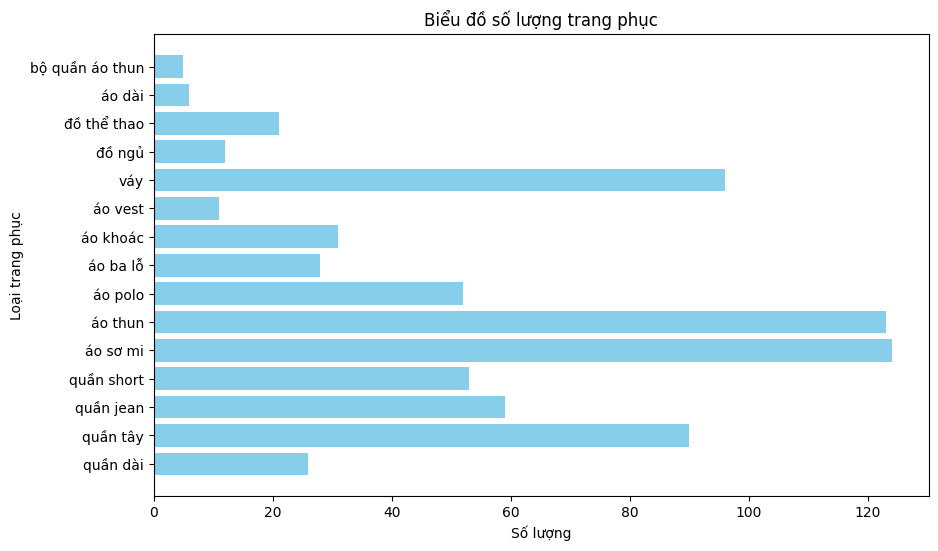

In [44]:
import matplotlib.pyplot as plt
# Chia dictionary thành các keys và values

items = list(dictionary.keys())
values = list(dictionary.values())

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
plt.barh(items, values, color='skyblue')
plt.xlabel('Số lượng')
plt.ylabel('Loại trang phục')
plt.title('Biểu đồ số lượng trang phục')
plt.savefig('image.jpg')
plt.show()

In [ ]:
def split_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.split()
    return text

split_text('Tôi cần tìm .... sản phẩm abc?? ??')


In [ ]:
def split_labels(label):
    label = label.lower()
    label = re.sub(r'[\[\]"]', '', label, flags=re.UNICODE)
    # label = label.replace('"',' ')
    label = [l.strip() for l in label.split(',') if l !='']
    if len(label) == 1 and '' in label:
        return []
    return label
label = """[quần dài, quần tây, quần jean]""" 
split_labels(label)

In [46]:
import pandas as pd
import torch
import re
import ast
class ProcessData():
    # đọc dữ liệu
    def __init__(self, max_length=10):  # Thêm max_length
        self.vocabulary_decoder = {}
        self.labels_decoder = {}
        self.vocabulary_encoder = {}
        self.labels_encoder = {}
        self.max_length = max_length  # Lưu max_length làm thuộc tính
        self.genders = set()
        self.sizes = set()
        self.colors = set()
        self.subcategoies = set()

    # gán dữ liệu và khởi tạo
    def set_data(self,data):
        self.raw_data = data
        self.init()

    #Đọc từ file csv
    def load_raw_data(self,path):
        self.raw_data = pd.read_csv(path)
        self.init()

    #Load lại dữ liệu đã train
    def load_saved_data(self,vocab_encoder:dict,label_encoder:dict,subcategories:set,colors:set,sizes:set,genders:set):
        self.labels_encoder = label_encoder
        self.vocabulary_encoder =vocab_encoder
        self.vocabulary_decoder = {v: k for k, v in vocab_encoder.items()}
        self.labels_decoder = {v: k for k, v in label_encoder.items()}
        self.genders = genders
        self.subcategoies = subcategories
        self.colors = colors
        self.sizes = sizes

    @staticmethod
    def split_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)
        text = text.split()
        return text
    
    @staticmethod
    def split_labels(labels):
        labels = labels.lower()
        labels = re.sub(r'[\[\]"]', '', labels, flags=re.UNICODE)
        # label = label.replace('"',' ')
        labels = [l.strip() for l in labels.split(',') if l !='']
        if len(labels) == 1 and '' in labels:
            return []
        return labels
    
    def init(self):
        vocab = set()
        labels = set()
        for index, row in self.raw_data.iterrows():
            text = row.iloc[0]
            text = self.split_text(text)
            
            subcategories = row.iloc[1]
            colors = row.iloc[2]
            sizes = row.iloc[3]
            genders = row.iloc[4]

            subcategories = self.split_labels(subcategories)
            colors = self.split_labels(colors)
            sizes = self.split_labels(sizes)
            genders = self.split_labels(genders)
            if(len(subcategories) >0):
                self.subcategoies.update(subcategories)
            if(len(colors)>0):
                self.colors.update(colors)
            if(len(sizes)>0):
                self.sizes.update( sizes)
            if(len(genders)>0):
                self.genders.update( genders)
            vocab.update(text)
            labels.update(subcategories)
            labels.update(colors)
            labels.update(sizes)
            labels.update(genders)

        vocab = ['UNK']+ sorted(list(vocab)) + ['<PAD>']
        labels = sorted(list(labels)) 
        
        for index, value in enumerate(vocab):
            if(value.strip()==''):continue
            self.vocabulary_encoder[value.strip()] = index
            self.vocabulary_decoder[index] = value.strip()
        for index, value in enumerate(labels):
            if(value.strip() == ''):continue
            self.labels_encoder[value.strip()] = index
            self.labels_decoder[index] = value.strip()
    
    def get_vocab_size(self):
        return len(self.vocabulary_decoder)
    
    def get_labels_size(self):
        return len(self.labels_decoder)
    def decode_labels(self, encoded_labels):
        # Giải mã chỉ số thành nhãn
        encoded_labels = encoded_labels.tolist() if isinstance(encoded_labels, torch.Tensor) else encoded_labels
        return [self.labels_decoder.get(idx+1, "") for idx,probabilaty in enumerate(encoded_labels) if probabilaty==1]
    def encode_text(self, text):
        # Mã hóa văn bản thành chỉ số và thêm padding nếu cần
        padding = [0]*self.max_length
        text = self.split_text(text)
        encoded_text = [self.vocabulary_encoder.get(t, 0) for t in text]  # Sử dụng 0 cho từ không tìm thấy
        
        # Padding văn bản nếu ngắn hơn max_length
        if len(encoded_text) < self.max_length:
            padding[len(encoded_text):] = [1]*len(padding[len(encoded_text):])
            encoded_text += [self.vocabulary_encoder['<PAD>']] * (self.max_length - len(encoded_text))
        else:
            encoded_text = encoded_text[:self.max_length]  # Cắt văn bản nếu dài hơn max_length
        return torch.tensor(encoded_text, dtype=torch.long),torch.tensor(padding).to(torch.bool)
    
    def decode_text(self, encoded_text):
        encoded_text = encoded_text.tolist() if isinstance(encoded_text, torch.Tensor) else encoded_text
        # Giải mã chỉ số thành văn bản
        return " ".join([self.vocabulary_decoder.get(idx, "") for idx in encoded_text])
    
    def get_data(self):
        inputs = []
        targets = []
        paddings = []
        for index, row in self.raw_data.iterrows():
            text = row.iloc[0]
            label = f'{row.iloc[1]}, {row.iloc[2]} , {row.iloc[3]} , {row.iloc[4]}'
            
            # Mã hóa các từ trong văn bản thành chỉ số
            x,padding = self.encode_text(text)
            
            # Mã hóa nhãn
            y = [0] * self.get_labels_size()
            for lbl in self.split_labels(label):
                if lbl.strip() in self.labels_encoder:
                    y[self.labels_encoder[lbl.strip()]-1] = 1
            # Chuyển y thành tensor trước khi thêm vào
            targets.append(torch.tensor(y, dtype=torch.float))
            inputs.append(x)
            paddings.append(padding)
            # targets.append(y)
        
        inputs = torch.stack(inputs)  # Chuyển thành tensor batch
        targets = torch.stack(targets)
        paddings = torch.stack(paddings)
        return inputs,paddings, targets
    


In [ ]:
if __name__ == "__main__":
    textProcessing = ProcessData(max_length=10)
    textProcessing.load_raw_data(r'data.csv')
    
    label = '[quần tây, áo sơ mi, nam]'
    encoded_labels = textProcessing.encode_labels(label)
    print("Encoded labels:", encoded_labels)
    
    decoded_labels = textProcessing.decode_labels(encoded_labels)
    print("Decoded labels:", decoded_labels)


# Xây dựng mô hình

In [206]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

class FeedFoward(nn.Module):
    def __init__(self, n_embd=128,rate = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(rate),
        )

    def forward(self, x):
        return self.net(x)
        
        

class TransfomerBlock(nn.Module):
    def __init__(self,n_embd=64,n_head = 1,rate = 0.1):
        super().__init__()
        self.sa = nn.MultiheadAttention(embed_dim=n_embd, num_heads=n_head, batch_first=True)
        
        self.ffwd = FeedFoward(n_embd)
        
        self.ln1 = nn.LayerNorm(n_embd)
        
        self.ln2 = nn.LayerNorm(n_embd)
        
        self.dropout1 = nn.Dropout(rate)

        self.dropout2 = nn.Dropout(rate)
    def forward(self, x,padding,is_train = True):

        attention_output,wei = self.sa(query=x,key=x,value =x,key_padding_mask = padding)
        if(is_train==False):
            attention_weights = wei[0] 
            attention_weights = attention_weights.detach().cpu().numpy()
            plt.figure(figsize=(8, 6))
            sns.heatmap(attention_weights, cmap='viridis', annot=True, cbar=True)
            plt.title("Attention Weights Heatmap")
            plt.xlabel("Key Tokens")
            plt.ylabel("Query Tokens")
            plt.show()
        attention_output = self.dropout1(attention_output)
        
        out1 = self.ln1(attention_output + x)
        
        ffwd_output = self.ffwd(out1)
        
        ffwd_ouput = self.dropout2(ffwd_output)
        
        return self.ln2(out1 + ffwd_ouput)


class MultiLabelClassifier(nn.Module):
    def __init__(self, vocab_size, sequence_length, output_dim, n_embd=16):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(sequence_length, n_embd)
        # self.transfomer = TransfomerBlock(n_embd)
        # self.transfomer = nn.Linear(n_embd,n_embd)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=n_embd, nhead=4, dim_feedforward=n_embd*4, dropout=0.1)
        self.transfomer = nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.output = nn.Linear(n_embd,output_dim)

    def forward(self,x,padding,is_train = True):
        B,T = x.shape
        token_embd = self.token_embedding_table(x)
        pos_embd = self.position_embedding_table(torch.arange(T))
        x = token_embd + pos_embd
        #temp
        # x = self.transfomer(x)
        # x = self.transfomer(x,padding,is_train)
        x = x.permute(1, 0, 2)

        x = self.transfomer(x,src_key_padding_mask = padding)

        x = x.permute(1, 0, 2)

        mask = (~padding).unsqueeze(-1).float()
        x_masked = x * mask
        sum_x = x_masked.sum(dim=1)
        count = mask.sum(dim=1).clamp(min=1)
        mean_x = sum_x / count
        x = mean_x
        x = self.output(x)
        x = x.squeeze(1)
        x = torch.sigmoid(x)
        return x
    

In [174]:
model = MultiLabelClassifier(sequence_length=100,vocab_size=200,output_dim=20)
model


MultiLabelClassifier(
  (token_embedding_table): Embedding(200, 16)
  (position_embedding_table): Embedding(100, 16)
  (transfomer): TransfomerBlock(
    (sa): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (ffwd): FeedFoward(
      (net): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=16, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (ln1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (output): Linear(in_features=16, out_features=20, bias=True)
)

# Training


In [175]:
# Cấu hình
# import module
import torch
import torch.nn as nn
import torch.optim as optim

sequence_length = 20

path = r'data1.csv'
dataset = ProcessData(max_length=sequence_length)
dataset.load_raw_data(path)
X_tensor,padding_tensor, y_tensor = dataset.get_data()
# Tạo các chỉ số ngẫu nhiên
indices = torch.randperm(X_tensor.size(0))
X_tensor = X_tensor[indices]
y_tensor = y_tensor[indices]
padding_tensor = padding_tensor[indices]
y_tensor = y_tensor.float()
print('X_tensor Shape: ',X_tensor.shape)

X_tensor Shape:  torch.Size([179, 20])


In [50]:
for i in range(len(X_tensor)):
    print('Encoded Description: ',X_tensor[i])
    print('Encoded Labels',y_tensor[i])
    print(dataset.decode_text(X_tensor[i]))
    print(dataset.decode_labels(y_tensor[i]))
    print('=============')

Encoded Description:  tensor([275, 219, 312,  72, 249,  48, 290,  37, 267, 341, 341, 341, 341, 341,
        341, 341, 341, 341, 341, 341])
Encoded Labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tôi sẽ đi dự tiệc cưới vào cuối tuần <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
['quần tây', 'váy', 'áo sơ mi']
Encoded Description:  tensor([139, 134, 133,  16, 202, 306, 230, 329, 312,  66,  44, 286,   7, 212,
        341, 341, 341, 341, 341, 341])
Encoded Labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
mình muốn mua bộ quần áo thun để đi dạo công viên buổi sáng <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
['']
Encoded Description:  tensor([275, 134, 331, 243, 225, 170, 163, 329, 312, 280, 303, 341, 341, 341,
        341, 341, 341, 341, 341, 341])
Encoded Labels tensor([0., 0., 0., 0., 0., 

In [176]:
train_size = int(0.9* len(X_tensor))

train_data = X_tensor[:train_size],y_tensor[:train_size]
padding_train_data = padding_tensor[:train_size]

valid_data = X_tensor[train_size:],y_tensor[train_size:]
padding_valid_data = padding_tensor[train_size:]

print(f'X_tensor.shape: {X_tensor.shape}')
print(f'Train data.shape: {train_data[0].shape}')
print(f'Train label.shape: {train_data[1].shape}')
print(f'padding train data.shape: {padding_train_data.shape}')
print(f'valid data.shape: {valid_data[0].shape}')
print(f'valid label.shape: {valid_data[1].shape}')
print(f'padding valid data.shape: {padding_valid_data.shape}')

X_tensor.shape: torch.Size([179, 20])
Train data.shape: torch.Size([161, 20])
Train label.shape: torch.Size([161, 30])
padding train data.shape: torch.Size([161, 20])
valid data.shape: torch.Size([18, 20])
valid label.shape: torch.Size([18, 30])
padding valid data.shape: torch.Size([18, 20])


In [6]:
for i in range(len(train_data[0])):
    print('Encoded Description: ',train_data[0][i])
    print('Encoded Labels',train_data[1][i])
    print(dataset.decode_text(train_data[0][i]))
    print(dataset.decode_labels(train_data[1][i]))
    print('=============')

Encoded Description:  tensor([313,   3, 108,   5, 133,  82, 144, 315, 315, 341, 341, 341, 341, 341,
        341, 341, 341, 341, 341, 341])
Encoded Labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
đá banh không biết mua gì mặc đây đây <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
['đồ thể thao']
Encoded Description:  tensor([186,  50, 331, 229, 137,  24,  25, 312,  29,  37, 267, 341, 341, 341,
        341, 341, 341, 341, 341, 341])
Encoded Labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
nữ cần đồ thoải mái cho chuyến đi chơi cuối tuần <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
['nữ', 'quần short', 'váy', 'áo thun']
Encoded Description:  tensor([148,  50, 252, 197, 229, 137, 329, 312,  41,  39, 341, 341, 341, 341,
        341, 341, 341, 341, 341, 341])
Encoded Labels te

In [150]:
def get_batch():
    idx = torch.randint(0,train_size,(16,))
    inputs = train_data[0]
    labels = train_data[1]
    x = [inputs[i] for i in idx]
    padding = [padding_train_data[i] for i in idx]
    y = [labels[i] for i in idx]
    return torch.stack(x),torch.stack(padding),torch.stack(y)
x,padding,y =get_batch()
print('inputs shape',x.shape)
print('padding shape',padding.shape)
print('labels',y.shape)

inputs shape torch.Size([16, 20])
padding shape torch.Size([16, 20])
labels torch.Size([16, 30])


In [91]:
@torch.no_grad()
def estimate_loss():
    model.eval()
    losses = torch.zeros(len(valid_data[0]))
    for i in range(len(valid_data[0])):
        x,padding,y = valid_data[0][i],padding_valid_data[i],valid_data[1][i]
        x = x.unsqueeze(dim=0)
        y = y.unsqueeze(dim=0)
        padding = padding.unsqueeze(dim=0)
        model(x,padding)
        outputs = model(x,padding)
        loss = criterion(outputs, y)
        losses[i] = loss.item()
    model.train()
    return losses.mean()


In [151]:
sequence_length = 20
vocab_size = dataset.get_vocab_size()
output_dim = dataset.get_labels_size()
print(f"sequence length: {sequence_length}")
print(f'vocab size: {vocab_size}')
print(f'output dim: {output_dim}')

sequence length: 20
vocab size: 251
output dim: 30


In [207]:
model = MultiLabelClassifier(sequence_length=sequence_length,
                                    vocab_size=vocab_size,
                                    output_dim=output_dim)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4)
steps = 20000
model.train()
train_loss = 0
val_losses = []
train_losses = []
for step in range(steps):
    optimizer.zero_grad()
    x, padding, y = get_batch()
    outputs = model(x,padding)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    if (step+1) % 200 == 0:
        train_loss /= 200
        val_loss = estimate_loss()
        val_losses.append(val_loss.item())
        train_losses.append(train_loss)
        print(f"step [{step+1}/{steps}], Loss: {train_loss:.4f} || Valid loss: {val_loss: .4f}")
        train_loss = 0

step [200/20000], Loss: 0.6132 || Valid loss:  0.5146
step [400/20000], Loss: 0.4608 || Valid loss:  0.4259
step [600/20000], Loss: 0.3955 || Valid loss:  0.3715
step [800/20000], Loss: 0.3518 || Valid loss:  0.3351
step [1000/20000], Loss: 0.3221 || Valid loss:  0.3101
step [1200/20000], Loss: 0.2989 || Valid loss:  0.2936
step [1400/20000], Loss: 0.2838 || Valid loss:  0.2836
step [1600/20000], Loss: 0.2782 || Valid loss:  0.2780
step [1800/20000], Loss: 0.2720 || Valid loss:  0.2722
step [2000/20000], Loss: 0.2653 || Valid loss:  0.2679
step [2200/20000], Loss: 0.2592 || Valid loss:  0.2592
step [2400/20000], Loss: 0.2513 || Valid loss:  0.2572
step [2600/20000], Loss: 0.2397 || Valid loss:  0.2508
step [2800/20000], Loss: 0.2342 || Valid loss:  0.2463
step [3000/20000], Loss: 0.2222 || Valid loss:  0.2410
step [3200/20000], Loss: 0.2111 || Valid loss:  0.2358
step [3400/20000], Loss: 0.2072 || Valid loss:  0.2311
step [3600/20000], Loss: 0.1995 || Valid loss:  0.2277
step [3800/200

KeyboardInterrupt: 

In [20]:
print(val_losses)
print(train_losses)

[0.33809763193130493, 0.2973115146160126, 0.2891765534877777, 0.27462053298950195, 0.2582528293132782, 0.24829773604869843, 0.23901592195034027, 0.23143741488456726, 0.22584882378578186, 0.2180098593235016, 0.21492351591587067, 0.21194659173488617, 0.21111303567886353, 0.21077799797058105, 0.2093881368637085, 0.210706427693367, 0.21002918481826782, 0.20978420972824097, 0.20940639078617096, 0.2098594456911087, 0.21254010498523712, 0.21522653102874756, 0.21689340472221375, 0.21834981441497803, 0.21898017823696136]
[0.4848689462244511, 0.30778888389468195, 0.2860269658267498, 0.2732787597924471, 0.25344247080385685, 0.24039390340447425, 0.22500311926007271, 0.2127794200927019, 0.1989769109338522, 0.18549078047275544, 0.17012372709810733, 0.16145640973001718, 0.14817661959677936, 0.13754591953009368, 0.12589204885065555, 0.11832722742110491, 0.10741338331252337, 0.10179028272628785, 0.09551605071872472, 0.08762760389596223, 0.08204740017652512, 0.07515611998736858, 0.06955862855538726, 0.0

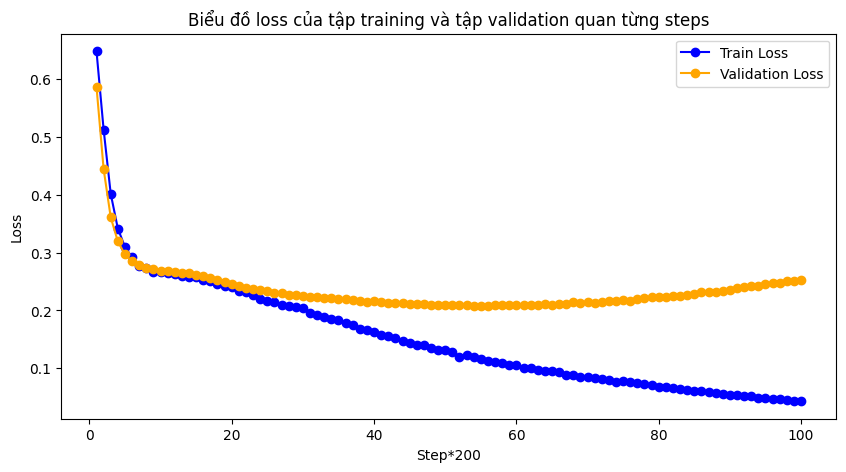

In [192]:
import matplotlib.pyplot as plt


epochs = range(1, int(20000/200)+1)  


# Tạo biểu đồ
plt.figure(figsize=(10, 5))

# Vẽ train loss
plt.plot(epochs, train_losses, label="Train Loss", marker='o', color='blue')

# Vẽ val loss
plt.plot(epochs, val_losses, label="Validation Loss", marker='o', color='orange')

# Thiết lập các thuộc tính của biểu đồ
plt.xlabel("Step*200")
plt.ylabel("Loss")
plt.title("Biểu đồ loss của tập training và tập validation quan từng steps")
plt.legend()  # Hiển thị chú thích
plt.savefig('loss.jpg')
plt.show()


Lưu mô hình

In [23]:
checkpoint = {
    'vocab':dataset.vocabulary_encoder,
    'labels':dataset.labels_encoder,
    'model_state_dict':model.state_dict(),
    'max_length':sequence_length,
    'genders': dataset.genders,
    'colors': dataset.colors,
    'subcategories': dataset.subcategoies,
    'sizes':dataset.sizes,
}

torch.save(checkpoint,'checkpoint1.pth')


In [214]:
model.eval()
t = 'nam' 
x,padding =dataset.encode_text(t)
padding = padding.unsqueeze(0)
x = x.unsqueeze(0)
pred = model(x,padding,is_train = True)
pred = pred.squeeze()
pred = (pred > 0.5).int()
print('Input: ',dataset.decode_text(x.squeeze()))
print('Nhãn dự đoán',dataset.decode_labels(pred))

Input:  nam <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Nhãn dự đoán ['nam']


In [202]:
model.eval()
for i in range(10):
    x,padding,y = valid_data[0][i],padding_valid_data[i],valid_data[1][i]
    padding = padding.unsqueeze(0)
    x = x.unsqueeze(0)
    pred = model(x,padding,is_train = True)
    pred = pred.squeeze()
    pred = (pred > 0.5).int()
    print('Input: ',dataset.decode_text(x.squeeze()))
    print('Nhãn dự đoán',dataset.decode_labels(pred))
    print('Nhãn đúng',dataset.decode_labels(y))
    print('============================================')

Input:  nam cần áo sơ mi để đi dự lễ cưới <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Nhãn dự đoán ['nam', 'áo sơ mi']
Nhãn đúng ['nam', 'áo sơ mi']
Input:  tìm cho tôi áo phù hợp cho người gầy đi <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Nhãn dự đoán ['nam', 'rất nhỏ', 'áo polo', 'áo sơ mi', 'áo thun']
Nhãn đúng ['nhỏ', 'áo polo', 'áo sơ mi', 'áo thun']
Input:  thấp bé quá nên chọn đồ khó khăn do vậy hãy tìm giúp tôi áo nào phù hợp đi <PAD>
Nhãn dự đoán []
Nhãn đúng ['nhỏ', 'rất nhỏ', 'áo polo', 'áo sơ mi', 'áo thun']
Input:  tôi là một người gầy nhưng lại thích áo có kích thước lớn tìm giúp tôi <PAD> <PAD> <PAD> <PAD>
Nhãn dự đoán ['nhỏ', 'áo polo', 'áo sơ mi', 'áo thun']
Nhãn đúng ['lớn', 'rất lớn', 'áo polo', 'áo sơ mi', 'áo thun']
Input:  đồ tập thể dục <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Nhãn dự đoán ['nữ', 'đồ thể thao']
Nhãn đúng ['đồ thể thao']
Input:  nam cần tìm áo sơ mi để mặc <PAD

In [ ]:
dataset.labels_decoder